# Evaluating your SAE

Code based off Rob Graham's ([themachinefan](https://github.com/themachinefan)) SAE evaluation code.

In [1]:
import os
os.getcwd()

'/workspace/ViT-Prisma/src/vit_prisma/sae/evals'

In [2]:
import einops
import torch
import torchvision

import plotly.express as px

from tqdm import tqdm

import numpy as np
import os
import requests

# Setup

In [3]:
from dataclasses import dataclass
from vit_prisma.sae.config import VisionModelSAERunnerConfig


@dataclass
class EvalConfig(VisionModelSAERunnerConfig):
    # sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-10-hook_mlp_out-l1-0.0001
    # sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-11-hook_resid_post-l1-0.0001
    sae_path: str = '/workspace/sae_checkpoints/sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-11-hook_resid_post-l1-0.0001/n_images_2600058.pt'
    model_name: str = "open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
    model_type: str =  "clip"
    patch_size: str = 32

    dataset_path = "/workspace"
    dataset_train_path: str = "/workspace/ILSVRC/Data/CLS-LOC/train"
    dataset_val_path: str = "/workspace/ILSVRC/Data/CLS-LOC/val"

    verbose: bool = True

    device: bool = 'cuda'

    eval_max: int = 50_000 # 50_000
    batch_size: int = 32

    # make the max image output folder a subfolder of the sae path


    @property
    def max_image_output_folder(self) -> str:
        # Get the base directory of sae_checkpoints
        sae_base_dir = os.path.dirname(os.path.dirname(self.sae_path))
        
        # Get the name of the original SAE checkpoint folder
        sae_folder_name = os.path.basename(os.path.dirname(self.sae_path))
        
        # Create a new folder path in sae_checkpoints/images with the original name
        output_folder = os.path.join(sae_base_dir, 'max_images', sae_folder_name)
        output_folder = os.path.join(output_folder, f"layer_{self.hook_point_layer}") # Add layer number

        
        # Ensure the directory exists
        os.makedirs(output_folder, exist_ok=True)
        
        return output_folder

cfg = EvalConfig()

n_tokens_per_buffer (millions): 0.032
Lower bound: n_contexts_per_buffer (millions): 0.00064
Total training steps: 158691
Total training images: 13000000
Total wandb updates: 15869
Expansion factor: 16
n_tokens_per_feature_sampling_window (millions): 204.8
n_tokens_per_dead_feature_window (millions): 1024.0
Using Ghost Grads.
We will reset the sparsity calculation 158 times.
Number tokens in sparsity calculation window: 4.10e+06
Gradient clipping with max_norm=1.0
Using SAE initialization method: encoder_transpose_decoder


In [4]:
torch.set_grad_enabled(False)

## Load model

In [5]:
from vit_prisma.models.base_vit import HookedViT

model_name = "open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
model = HookedViT.from_pretrained(model_name, is_timm=False, is_clip=True).to(cfg.device)
 

model_id download_pretrained_from_hf: laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
Official model name open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
Converting OpenCLIP weights
model_id download_pretrained_from_hf: laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
visual projection shape torch.Size([768, 512])
Setting center_writing_weights to False for OpenCLIP
Setting fold_ln to False for OpenCLIP
Loaded pretrained model open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K into HookedTransformer


## Load datasets

In [6]:
import importlib
import vit_prisma
# importlib.reload(vit_prisma.dataloaders.imagenet_dataset)

In [7]:
# load dataset
import open_clip
from vit_prisma.utils.data_utils.imagenet_utils import setup_imagenet_paths
from vit_prisma.dataloaders.imagenet_dataset import get_imagenet_transforms_clip, ImageNetValidationDataset

from torchvision import transforms
from transformers import CLIPProcessor

og_model_name = "hf-hub:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
og_model, _, preproc = open_clip.create_model_and_transforms(og_model_name)
processor = preproc

size=224

data_transforms = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                     std=[0.26862954, 0.26130258, 0.27577711]),
])
    
imagenet_paths = setup_imagenet_paths(cfg.dataset_path)
imagenet_paths["train"] = "/workspace/ILSVRC/Data/CLS-LOC/train"
imagenet_paths["val"] = "/workspace/ILSVRC/Data/CLS-LOC/val"
imagenet_paths["val_labels"] = "/workspace/LOC_val_solution.csv"
imagenet_paths["label_strings"] = "/workspace/LOC_synset_mapping.txt"
print()
train_data = torchvision.datasets.ImageFolder(cfg.dataset_train_path, transform=data_transforms)
val_data = ImageNetValidationDataset(cfg.dataset_val_path, 
                                imagenet_paths['label_strings'], 
                                imagenet_paths['val_labels'], 
                                data_transforms,
                                return_index=True,
)
val_data_visualize = ImageNetValidationDataset(cfg.dataset_val_path, 
                                imagenet_paths['label_strings'], 
                                imagenet_paths['val_labels'],
                                torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),]), return_index=True)

print(f"Validation data length: {len(val_data)}") if cfg.verbose else None



Validation data length: 50000


In [8]:
from vit_prisma.sae.training.activations_store import VisionActivationsStore
# import dataloader
from torch.utils.data import DataLoader

# activations_loader = VisionActivationsStore(cfg, model, train_data, eval_dataset=val_data)
val_dataloader = DataLoader(val_data, batch_size=cfg.batch_size, shuffle=False, num_workers=4)


## Load pretrained SAE to evaluate

In [9]:
from vit_prisma.sae.sae import SparseAutoencoder
sparse_autoencoder = SparseAutoencoder(cfg).load_from_pretrained("/workspace/sae_checkpoints/sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-11-hook_resid_post-l1-0.0001/n_images_2600058.pt")
sparse_autoencoder.to(cfg.device)
sparse_autoencoder.eval()  # prevents error if we're expecting a dead neuron mask for who 


get_activation_fn received: activation_fn=relu, kwargs={}
n_tokens_per_buffer (millions): 0.032
Lower bound: n_contexts_per_buffer (millions): 0.00064
Total training steps: 158691
Total training images: 13000000
Total wandb updates: 1586
Expansion factor: 64
n_tokens_per_feature_sampling_window (millions): 204.8
n_tokens_per_dead_feature_window (millions): 1024.0
Using Ghost Grads.
We will reset the sparsity calculation 158 times.
Number tokens in sparsity calculation window: 4.10e+06
Gradient clipping with max_norm=1.0
Using SAE initialization method: encoder_transpose_decoder
get_activation_fn received: activation_fn=relu, kwargs={}


SparseAutoencoder(
  (hook_sae_in): HookPoint()
  (hook_hidden_pre): HookPoint()
  (hook_hidden_post): HookPoint()
  (hook_sae_out): HookPoint()
  (activation_fn): ReLU()
)

## Clip Labeling AutoInterp

In [10]:
# all_imagenet_class_names

In [11]:
from vit_prisma.dataloaders.imagenet_dataset import get_imagenet_index_to_name
ind_to_name = get_imagenet_index_to_name()

all_imagenet_class_names = []
for i in range(len(ind_to_name)):
    all_imagenet_class_names.append(ind_to_name[str(i)][1])

In [12]:
cfg.max_image_output_folder

'/workspace/sae_checkpoints/max_images/sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-11-hook_resid_post-l1-0.0001/layer_9'

## Feature steering

In [13]:
def steering_hook_fn_cls_only(
    activations, cfg, hook, sae, steering_indices, steering_strength=1.0, mean_ablation_values=None, include_error=False

):
    sae.to(activations.device)


    sae_input = activations.clone()
    sae_output, feature_activations, *data = sae(sae_input)
    
    steered_feature_activations = feature_activations.clone()
    
    # batch, stream, feats
    # cls token is *last* in sequence
    steered_feature_activations[:, 0, steering_indices] = steering_strength

    steered_sae_out = einops.einsum(
                steered_feature_activations,
                sae.W_dec,
                "... d_sae, d_sae d_in -> ... d_in",
            ) + sae.b_dec

    steered_sae_out = sae.run_time_activation_norm_fn_out(steered_sae_out)
    
    # print(f"steering norm: {(steered_sae_out - sae_output).norm()}")
    
    

    if include_error:
        error = sae_input - sae_output
        # print(f"error.norm(): {error.norm()}")
        return steered_sae_out + error
    return steered_sae_out


def steering_hook_fn(
    activations, cfg, hook, sae, steering_indices, steering_strength=1.0, mean_ablation_values=None, include_error=False

):
    sae.to(activations.device)


    sae_input = activations.clone()
    sae_output, feature_activations, *data = sae(sae_input)
    
    steered_feature_activations = feature_activations.clone()
    
    steered_feature_activations[:, :, steering_indices] = steering_strength

    steered_sae_out = einops.einsum(
                steered_feature_activations,
                sae.W_dec,
                "... d_sae, d_sae d_in -> ... d_in",
            ) + sae.b_dec

    steered_sae_out = sae.run_time_activation_norm_fn_out(steered_sae_out)
    
    # print(f"steering norm: {(steered_sae_out - sae_output).norm()}")
    
    

    if include_error:
        error = sae_input - sae_output
        # print(f"error.norm(): {error.norm()}")
        return steered_sae_out + error
    return steered_sae_out

In [14]:
random_feat_idxs = np.random.randint(0, high=3000, size=(5))
random_feat_idxs[0] = 655
random_feat_idxs[1] = 656
random_feat_idxs[2] = 665
random_feat_idxs[3] = 2541

In [15]:
# for a given feature, set it high/low on maxim activ. imgs and high/low on non-activ images
# hook SAE and replace desired feature with 0 or 1 
from typing import List, Dict, Tuple
import torch
import einops
from tqdm import tqdm

from functools import partial

@torch.no_grad()
def compute_feature_activations_set_feat(
    images: torch.Tensor,
    model: torch.nn.Module,
    sparse_autoencoder: torch.nn.Module,
    encoder_weights: torch.Tensor,
    encoder_biases: torch.Tensor,
    feature_ids: List[int],
    feature_categories: List[str],
    top_k: int = 10,
    steering_strength: float = 10.0
):
    """
    Compute the highest activating tokens for given features in a batch of images.
    
    Args:
        images: Input images
        model: The main model
        sparse_autoencoder: The sparse autoencoder
        encoder_weights: Encoder weights for selected features
        encoder_biases: Encoder biases for selected features
        feature_ids: List of feature IDs to analyze
        feature_categories: Categories of the features
        top_k: Number of top activations to return per feature

    Returns:
        Dictionary mapping feature IDs to tuples of (top_indices, top_values)
    """
#     _, cache = model.run_with_cache(images, names_filter=[sparse_autoencoder.cfg.hook_point])
    recons_image_embeddings_feat_altered_list = []
    for idx in np.array(range(sparse_autoencoder.W_dec.shape[0]))[random_feat_idxs]:
#         print(f"Feature: {idx} ====================")
        
        # steering_hook_fn, steering_hook_fn_cls_only
        steering_hook = partial(
            steering_hook_fn,
            cfg=cfg,
            sae=sparse_autoencoder,
            steering_indices=[idx],
            steering_strength=steering_strength,
            mean_ablation_values = [1.0],
            include_error=True,
            )
        
        
        recons_image_embeddings_feat_altered = model.run_with_hooks(
            images,
            fwd_hooks=[("blocks.9.hook_mlp_out", steering_hook)],
        )
        recons_image_embeddings_feat_altered_list.append(recons_image_embeddings_feat_altered)

    
    # output is in clip embedding space
    recons_image_embeddings_default = model.run_with_hooks(
        images,
        fwd_hooks=[("blocks.9.hook_mlp_out", lambda x, hook: x)],
    )
    
#     print(f"recons_image_embeddings_default: {recons_image_embeddings_default}")
#     print(f"recons_image_embeddings_default.shape: {recons_image_embeddings_default.shape}")
#     print(f"recons_image_embeddings_default: {recons_image_embeddings_default.shape}")

#     print(f"recons_image_embeddings_feat_altered: {recons_image_embeddings_feat_altered}")
#     print(f"recons_image_embeddings_feat_altered.shape: {recons_image_embeddings_feat_altered.shape}")

    return recons_image_embeddings_feat_altered_list, recons_image_embeddings_default

In [115]:
import torch
from PIL import Image

from collections import defaultdict
max_samples = cfg.eval_max

encoder_biases = sparse_autoencoder.b_enc#[interesting_features_indices]
encoder_weights = sparse_autoencoder.W_enc#[:, interesting_features_indices]

steering_strengths = [0.0, 5.0, 10.0, 20.0, 50.0, 150.0]#, 300.0]#, 500.0, 1000.0, 2000.0, 5000.0, 10000.0]#, -200.0, -300.0]


steering_strength_image_results = defaultdict(dict)
steering_strength_info = {}

og_model.cuda()




for steering_strength in steering_strengths:
    print(f"{'==============' * 2} steering_strength: {steering_strength} {'==============' * 2}")
    # ===== Get Steered and Default CLIP Outputs =====
    top_k=10
    processed_samples = 0
    default_embeds_list = []
    feature_steered_embeds = defaultdict(list)
    l = 0
    
    # remove tqdm
    for batch_images, _, batch_indices in tqdm(val_dataloader, total=max_samples // cfg.batch_size):
        batch_images = batch_images.to(cfg.device)
        batch_indices = batch_indices.to(cfg.device)
        batch_size = batch_images.shape[0]

        altered_embeds_list, default_embeds = compute_feature_activations_set_feat(
            batch_images, model, sparse_autoencoder, encoder_weights, encoder_biases,
            None, None, top_k, steering_strength
        )
        default_embeds_list.append(default_embeds)
        for j, altered_embeds in enumerate(altered_embeds_list):
            feature_steered_embeds[random_feat_idxs[j]].extend(altered_embeds)
        # either label embeds or optimize to maximal token in text transformer embedding face
        l += 1
        if l >= 1:
            break    
    default_embeds = torch.cat(default_embeds_list)
    
    with open("/workspace/clip_dissect_raw.txt", "r") as f:
        larger_vocab = [line[:-1] for line in f.readlines()][:5000]


    # ===== CLIP Embeds =====
    # use clip vocab here and compare embeds
    tokenizer = open_clip.get_tokenizer('ViT-B-32')
    text = tokenizer(larger_vocab)
    text_features = og_model.encode_text(text.cuda())
    text_features_normed = text_features/text_features.norm(dim=-1, keepdim=True)


    print(f"text_features_normed.shape: {text_features_normed.shape}")
    text_probs_altered_list = []
    with torch.no_grad(), torch.cuda.amp.autocast():
        for key in feature_steered_embeds:
            print(key)
            # embeds already have L2 norm of 1
            text_probs_altered = (100.0 * torch.stack(feature_steered_embeds[key]) @ text_features_normed.T).softmax(dim=-1)
            text_probs_altered_list.append(text_probs_altered)
        text_probs_default = (100.0 * default_embeds @ text_features_normed.T).softmax(dim=-1)

#     print("Label probs altered:", text_probs_altered.shape)  # prints: [[1., 0., 0.]]
#     print("Label probs default:", text_probs_default.shape)  # prints: [[1., 0., 0.]]
    
    
    # ===== Logit Difference =====
    # indexed as such in steering_strength_image_results:
    # per steering strength
    # per feature
    # per image
    
    selected_vocab = larger_vocab

    top_concept_per_feat = {}
    top_val_per_feat = {}
    top_diff_per_feat = {}
    top_ratio_per_feat = {}
    
    # run this for sampled features over all of imagenet eval
    for j, text_probs_altered in enumerate(text_probs_altered_list):
        print(f"{'============================================'*2}\n\nFor Feature {random_feat_idxs[j]}")
#         print("actual image content:")
        default_vals_softmax, default_idxs_softmax = torch.topk(text_probs_default,k=10)
#         print(default_vals_softmax, "\n", np.array(selected_vocab)[default_idxs_softmax.cpu()])


        logit_diff = text_probs_altered - text_probs_default
#         logit_diff_aggregate = logit_diff.sum(dim=0)
        logit_diff_aggregate = logit_diff.mean(dim=0)

        logit_ratio = text_probs_altered/text_probs_default
        logit_ratio_aggregate = logit_ratio.mean(dim=0)

        print(f"text_probs_altered.softmax(): {text_probs_altered.softmax(1).shape}")
        text_probs_altered_softmax = text_probs_altered.softmax(1)
        vals_softmax, idxs_softmax = torch.topk(text_probs_altered_softmax,k=10)

    #     print(f"text_probs_altered.softmax(): {text_probs_altered.sum(0).softmax(0).shape}")
    #     text_probs_altered_softmax_agg = text_probs_altered.sum(0).softmax(0)
    #     vals_softmax_agg, idxs_softmax_agg = torch.topk(text_probs_altered_softmax_agg,k=10)

#         print(f"\nSoftmax Over {text_probs_altered.shape[0]} Images:\n{vals_softmax}")
#         print(np.array(selected_vocab)[idxs_softmax.cpu()])
#         for i in range(vals_softmax.shape[0]):
#             print(vals_softmax[i], "\n", np.array(selected_vocab)[idxs_softmax.cpu()][i])
#             break

    #     print(f"\nAgg Softmax Over {text_probs_altered.shape[0]} Images:\n{vals_softmax_agg}")
    #     print(np.array(selected_vocab)[idxs_softmax_agg.cpu()])

        vals_agg, idxs_agg = torch.topk(logit_diff_aggregate,k=10)
        vals_least_agg, idxs_least_agg = torch.topk(logit_diff_aggregate,k=10,largest=False)

        ratios_agg, ratios_idxs_agg = torch.topk(logit_ratio_aggregate,k=10)
        ratios_least_agg, ratios_idxs_least_agg = torch.topk(logit_ratio_aggregate,k=10,largest=False)

        vals, idxs = torch.topk(logit_diff,k=5)
        vals_least, idxs_least = torch.topk(logit_diff,k=5,largest=False)

        ratios, ratios_idxs = torch.topk(logit_ratio,k=5)
        ratios_least, ratios_idxs_least = torch.topk(logit_ratio,k=5,largest=False)

        # random_feat_idxs[j] is the index of the feature
        for img_idx in range(batch_images.shape[0]):
            if random_feat_idxs[j] not in steering_strength_image_results[str(steering_strength)].keys():
                steering_strength_image_results[str(steering_strength)][random_feat_idxs[j].copy()] = []
            # entries are torch.topk(k=10) results
            steering_strength_image_results[str(steering_strength)][random_feat_idxs[j]].append((np.array(selected_vocab, copy=True)[idxs_softmax.cpu()][img_idx], torch.clone(vals_softmax[img_idx])))
        
        # per image
        top_concept_per_feat[random_feat_idxs[j]] = np.array(selected_vocab)[idxs_softmax.cpu()][0][0]
        top_val_per_feat[random_feat_idxs[j]] = vals_softmax[0][0]
        
        # aggregate
        top_diff_per_feat[random_feat_idxs[j]] = vals_agg[0]
        top_ratio_per_feat[random_feat_idxs[j]] = ratios_agg[0]


        print(f"\nMost Changed, by Absolute Diff Over {logit_diff.shape[0]} Images:\n{vals_agg}")
        print(np.array(selected_vocab)[idxs_agg.cpu()])
#         print(vals_least_agg)
#         print(np.array(selected_vocab)[idxs_least_agg.cpu()])

        print(f"\nMost Changed, by Ratio Over {logit_diff.shape[0]} Images:")
        print(ratios_agg)
        print(np.array(selected_vocab)[ratios_idxs_agg.cpu()])
#         print(ratios_least_agg)
#         print(np.array(selected_vocab)[ratios_idxs_least_agg.cpu()])
    
    steering_strength_info[steering_strength] = (top_concept_per_feat,top_val_per_feat,top_ratio_per_feat,top_diff_per_feat)


============================ steering_strength: 0.0 ============================


  0%|                                                                                                            | 0/1562 [00:00<?, ?it/s]


text_features_normed.shape: torch.Size([5000, 512])
655
656
665
2541
122

For Feature 655
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([6.6406e-07, 2.0476e-07, 1.9336e-07, 1.4133e-07, 7.6822e-08, 6.7587e-08,
        6.6595e-08, 6.1687e-08, 4.4404e-08, 4.3015e-08], device='cuda:0')
['leg' 'sharp' 'junior' 'speed' 'ride' 'game' 'vehicle' 'little' 'shared'
 'racing']

Most Changed, by Ratio Over 32 Images:
tensor([1.0005, 1.0005, 1.0005, 1.0005, 1.0002, 1.0002, 1.0002, 1.0002, 1.0002,
        1.0002], device='cuda:0')
['leg' 'sharp' 'second' 'half' 'pages' 'o' 'game' 'little' 'on' 'said']

For Feature 656
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([6.6406e-07, 2.0476e-07, 1.9336e-07, 1.4133e-07, 7.6822e-08, 6.7587e-08,
        6.6595e-08, 6.1687e-08, 4.4404e-08, 4.3015e-08], device='cuda:0')
['leg' 'sharp' 'junior' 'speed' 'ride' 'game' 'vehicle' 'little' 'shared

  0%|                                                                                                            | 0/1562 [00:00<?, ?it/s]


text_features_normed.shape: torch.Size([5000, 512])
655
656
665
2541
122

For Feature 655
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([0.0205, 0.0172, 0.0120, 0.0111, 0.0104, 0.0077, 0.0053, 0.0046, 0.0041,
        0.0035], device='cuda:0')
['flying' 'pair' 'fucking' 'python' 'playing' 'polish' 'white' 'pet' 'bed'
 'planet']

Most Changed, by Ratio Over 32 Images:
tensor([32.5402, 28.5258, 25.5722, 24.9162, 21.9108, 21.6070, 20.2170, 20.1892,
        20.0771, 18.1458], device='cuda:0')
['please' 'places' 'plain' 'plane' 'playing' 'place' 'plays' 'pleasure'
 'played' 'placed']

For Feature 656
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([0.0115, 0.0087, 0.0068, 0.0041, 0.0032, 0.0031, 0.0027, 0.0027, 0.0023,
        0.0023], device='cuda:0')
['pair' 'bears' 'flying' 'bowl' 'hunting' 'finished' 'dogs' 'tiny' 'stars'
 'glance']

Most Changed, by Ratio Over 32 Ima

  0%|                                                                                                            | 0/1562 [00:00<?, ?it/s]


text_features_normed.shape: torch.Size([5000, 512])
655
656
665
2541
122

For Feature 655
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([0.0500, 0.0255, 0.0150, 0.0149, 0.0136, 0.0098, 0.0074, 0.0074, 0.0067,
        0.0066], device='cuda:0')
['pair' 'flying' 'pet' 'playing' 'polish' 'dogs' 'fruit' 'fucking'
 'picture' 'seal']

Most Changed, by Ratio Over 32 Images:
tensor([382.4955, 344.7849, 342.3858, 275.9570, 245.2517, 209.8213, 206.3641,
        198.0874, 188.9310, 188.3532], device='cuda:0')
['please' 'platinum' 'pleasure' 'plays' 'places' 'plain' 'played'
 'players' 'plane' 'plenty']

For Feature 656
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([0.0169, 0.0159, 0.0147, 0.0085, 0.0064, 0.0062, 0.0061, 0.0053, 0.0050,
        0.0049], device='cuda:0')
['bears' 'pair' 'flying' 'tiny' 'dogs' 'bowl' 'dog' 'photo' 'pet'
 'finished']

Most Changed, by Ratio Over 

  0%|                                                                                                            | 0/1562 [00:00<?, ?it/s]


text_features_normed.shape: torch.Size([5000, 512])
655
656
665
2541
122

For Feature 655
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([0.0161, 0.0147, 0.0133, 0.0122, 0.0114, 0.0097, 0.0092, 0.0071, 0.0067,
        0.0055], device='cuda:0')
['wings' 'dogs' 'pets' 'tiny' 'flying' 'pair' 'phil' 'pet' 'visitors'
 'sweet']

Most Changed, by Ratio Over 32 Images:
tensor([133826.7344,   5354.4062,   3519.1711,   3463.9089,   2844.9778,
          2639.4111,   2581.5288,   2259.9067,   2211.7012,   2197.1709],
       device='cuda:0')
['editors' 'crystal' 'girls' 'jewelry' 'wonderful' 'wings' 'electronics'
 'flowers' 'otherwise' 'atmosphere']

For Feature 656
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([0.0200, 0.0132, 0.0111, 0.0109, 0.0103, 0.0084, 0.0067, 0.0067, 0.0065,
        0.0062], device='cuda:0')
['dogs' 'tiny' 'photo' 'photos' 'flying' 'pics' 'picture' 'pio

  0%|                                                                                                            | 0/1562 [00:00<?, ?it/s]


text_features_normed.shape: torch.Size([5000, 512])
655
656
665
2541
122

For Feature 655
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([0.0186, 0.0180, 0.0123, 0.0104, 0.0103, 0.0096, 0.0082, 0.0081, 0.0078,
        0.0072], device='cuda:0')
['breaks' 'until' 'ann' 'contains' 'twiki' 'tim' 'trouble' 'cooling'
 'angle' 'arms']

Most Changed, by Ratio Over 32 Images:
tensor([4319316.5000,  172565.4375,   83760.7891,   40228.2344,   38200.9648,
          36920.0508,   28849.2773,   20322.0508,   18654.0410,   16477.3301],
       device='cuda:0')
['editors' 'quotes' 'christmas' 'desk' 'ink' 'bands' 'authors' 'birds'
 'noted' 'crafts']

For Feature 656
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([0.0269, 0.0184, 0.0147, 0.0132, 0.0118, 0.0117, 0.0091, 0.0079, 0.0078,
        0.0075], device='cuda:0')
['border' 'studios' 'photos' 'custom' 'panasonic' 'giant' 'holder'

  0%|                                                                                                            | 0/1562 [00:00<?, ?it/s]


text_features_normed.shape: torch.Size([5000, 512])
655
656
665
2541
122

For Feature 655
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([0.0206, 0.0136, 0.0133, 0.0125, 0.0119, 0.0113, 0.0112, 0.0100, 0.0095,
        0.0086], device='cuda:0')
['ink' 'ann' 'cooling' 'until' 'twiki' 'and' 'und' 'arm' 'seek' 'shit']

Most Changed, by Ratio Over 32 Images:
tensor([3906904.2500, 1593101.6250,  373663.4375,  289097.8750,  179871.9219,
         155184.2344,  131413.0938,  114251.3750,   82929.0469,   82410.8438],
       device='cuda:0')
['editors' 'quotes' 'christmas' 'bands' 'ink' 'crafts' 'desk' 'brands'
 'colleges' 'bedroom']

For Feature 656
text_probs_altered.softmax(): torch.Size([32, 5000])

Most Changed, by Absolute Diff Over 32 Images:
tensor([0.0264, 0.0255, 0.0209, 0.0135, 0.0116, 0.0113, 0.0112, 0.0109, 0.0107,
        0.0103], device='cuda:0')
['boards' 'border' 'studios' 'setup' 'kong' 'used' 'hawaii' 'islands'
 'niko

In [116]:
steering_strength_image_results.keys(), steering_strength_image_results[str(steering_strength)].keys()

(dict_keys(['0.0', '5.0', '10.0', '20.0', '50.0', '150.0']),
 dict_keys([655, 656, 665, 2541, 122]))

In [125]:
i = 0
# 0: python, 3: bowl, 4: bed, 6: guinea
image_idx = 4
feat_num = 655

# to iterate over many features:
# for feat_num in steering_strength_image_results[str(steering_strength)].keys():

print(f"=====================\nfeat_num: {feat_num}")
feat_num_concept_arr = []
feat_num_prob_arr = []
for dict_key in steering_strengths:
    # image, tuple position, idx of top-k
    # modify this to do top-k at some point
    print(str(dict_key), steering_strength_image_results[str(dict_key)][feat_num][image_idx][0][0])
    feat_num_concept_arr.append((dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][0][0]))
    print(str(dict_key), steering_strength_image_results[str(dict_key)][feat_num][image_idx][1][0].item())
    feat_num_prob_arr.append((dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][1][0].item()))


feat_num: 655
0.0 bed
0.0 0.00027095453697256744
5.0 bed
5.0 0.0003087111981585622
10.0 bed
10.0 0.00024697629851289093
20.0 tiny
20.0 0.00021133718837518245
50.0 ann
50.0 0.00020400102948769927
150.0 ink
150.0 0.00020336468878667802


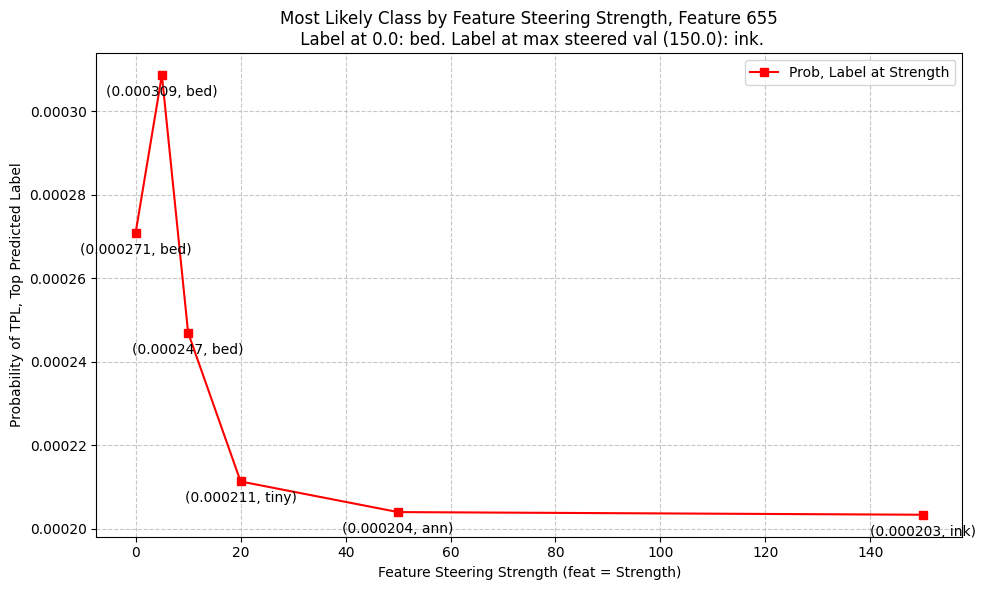

In [126]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = [tup[0] for tup in sorted(feat_num_concept_arr)]
y1 = [tup[1] for tup in sorted(feat_num_concept_arr)]
y2 = [tup[1] for tup in sorted(feat_num_prob_arr)]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each line with different colors and markers
plt.plot(np.array(x), y2, 'rs-', label='Prob, Label at Strength')  # Red line with squares

# Label each point
for i in range(len(x)):
    # Labels for series
    plt.annotate(f'({y2[i]:01f}, {y1[i]})', 
                (x[i], y2[i]), 
                textcoords="offset points", 
                xytext=(0,-15),
                ha='center')
    
# Customize the plot
plt.xlabel('Feature Steering Strength (feat = Strength)')
plt.ylabel('Probability of TPL, Top Predicted Label')
plt.title(f'Most Likely Class by Feature Steering Strength, Feature {feat_num}\n Label at 0.0: {steering_strength_image_results[str(0.0)][feat_num][image_idx][0][0]}. Label at max steered val ({str(max(steering_strengths))}): {steering_strength_image_results[str(max(steering_strengths))][feat_num][image_idx][0][0]}.')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent label overlap
plt.tight_layout()


# plt.savefig("test.svg")

# Show the plot
plt.show()

feat_num: 655
0.0 bed
0.0 0.00027095453697256744
5.0 bed
5.0 0.0003087111981585622
10.0 bed
10.0 0.00024697629851289093
20.0 tiny
20.0 0.00021133718837518245
50.0 ann
50.0 0.00020400102948769927
150.0 ink
150.0 0.00020336468878667802


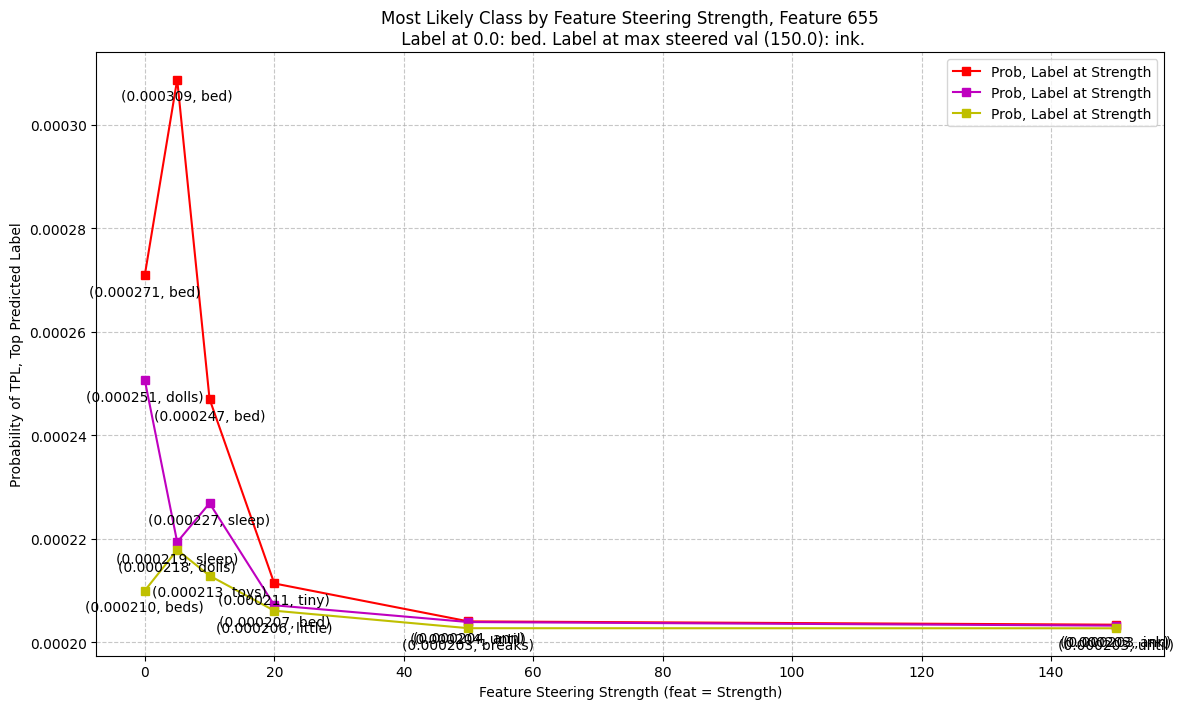

In [128]:
# top-k logits chart
i = 0
# 0: python, 3: bowl, 4: bed, 6: guinea
image_idx = 4
feat_num = feat_num

# to iterate over many features:
# for feat_num in steering_strength_image_results[str(steering_strength)].keys():

print(f"=====================\nfeat_num: {feat_num}")
feat_num_concept_arr = []
feat_num_concept_arr_2 = []
feat_num_concept_arr_3 = []
feat_num_prob_arr = []
feat_num_prob_arr_2 = []
feat_num_prob_arr_3 = []
for dict_key in steering_strengths:
    # image, tuple position, idx of top-k
    # modify this to do top-k at some point
    print(str(dict_key), steering_strength_image_results[str(dict_key)][feat_num][image_idx][0][0])
    feat_num_concept_arr.append((dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][0][0]))
    feat_num_concept_arr_2.append((dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][0][1]))
    feat_num_concept_arr_3.append((dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][0][2]))
    print(str(dict_key), steering_strength_image_results[str(dict_key)][feat_num][image_idx][1][0].item())
    feat_num_prob_arr.append((dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][1][0].item()))
    feat_num_prob_arr_2.append((dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][1][1].item()))
    feat_num_prob_arr_3.append((dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][1][2].item()))


# Sample data
x = [tup[0] for tup in sorted(feat_num_concept_arr)]
y1 = [tup[1] for tup in sorted(feat_num_concept_arr)]
y2 = [tup[1] for tup in sorted(feat_num_prob_arr)]
y1_2 = [tup[1] for tup in sorted(feat_num_concept_arr_2)]
y2_2 = [tup[1] for tup in sorted(feat_num_prob_arr_2)]
y1_3 = [tup[1] for tup in sorted(feat_num_concept_arr_3)]
y2_3 = [tup[1] for tup in sorted(feat_num_prob_arr_3)]

# Create the plot
plt.figure(figsize=(12, 9))

# Plot each line with different colors and markers
plt.plot(np.array(x), y2, 'rs-', label='Prob, Label at Strength')  # Red line with squares
plt.plot(np.array(x), y2_2, 'ms-', label='Prob, Label at Strength')  # Red line with squares
plt.plot(np.array(x), y2_3, 'ys-', label='Prob, Label at Strength')  # Red line with squares

# Label each point
for i in range(len(x)):
    # Labels for series
    plt.annotate(f'({y2[i]:01f}, {y1[i]})', 
                (x[i], y2[i]), 
                textcoords="offset points", 
                xytext=(0,-15),
                ha='center')
    plt.annotate(f'({y2_2[i]:01f}, {y1_2[i]})', 
                (x[i], y2_2[i]), 
                textcoords="offset points", 
                xytext=(0,-15),
                ha='center')
    plt.annotate(f'({y2_3[i]:01f}, {y1_3[i]})', 
                (x[i], y2_3[i]), 
                textcoords="offset points", 
                xytext=(0,-15),
                ha='center')
    
# Customize the plot
plt.xlabel('Feature Steering Strength (feat = Strength)')
plt.ylabel('Probability of TPL, Top Predicted Label')
plt.title(f'Most Likely Class by Feature Steering Strength, Feature {feat_num}\n Label at 0.0: {steering_strength_image_results[str(0.0)][feat_num][image_idx][0][0]}. Label at max steered val ({str(max(steering_strengths))}): {steering_strength_image_results[str(max(steering_strengths))][feat_num][image_idx][0][0]}.')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent label overlap
plt.tight_layout()


# plt.savefig("test.svg")

# Show the plot
plt.show()

In [120]:
# Steerability metric

0.0 tensor(6.6406e-07)
5.0 tensor(0.0102)
10.0 tensor(0.0181)
20.0 tensor(0.0189)
50.0 tensor(0.0402)
150.0 tensor(0.0693)
300.0 tensor(0.0903)
500.0 tensor(0.1125)
1000.0 tensor(0.1333)
2000.0 tensor(0.1451)
5000.0 tensor(0.1528)
10000.0 tensor(0.1554)


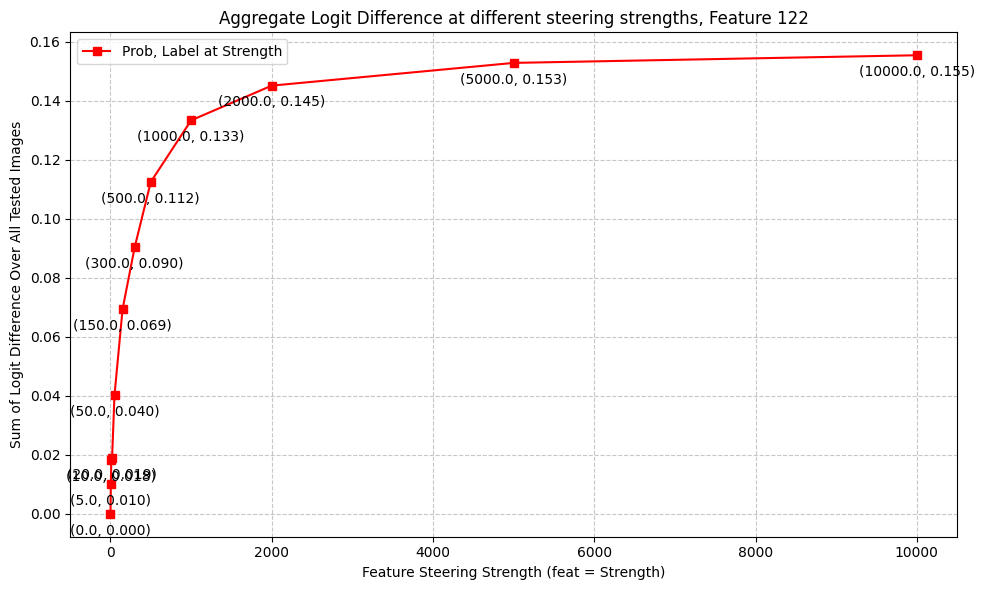

In [101]:
steering_strength_info
feat_num_steerability = feat_num
# steering_strength_info[steering_strength] = (top_concep,top_val,aggregate_ratio,aggregate_diff)
agg_diff_arr = []
i = 0
for key in steering_strength_info:
    print(key, steering_strength_info[key][3][feat_num].cpu())
    agg_diff_arr.append(steering_strength_info[key][3][feat_num_steerability].cpu().item())
#     agg_diff_arr.append(steering_strength_info[key][2][feat_num_steerability].cpu().item())
#     i += 1
#     if i > 3:
#         agg_diff_arr[-1] = agg_diff_arr[-2]

import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = [tup[0] for tup in sorted(feat_num_concept_arr)]
y1 = agg_diff_arr

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each line with different colors and markers
plt.plot(np.array(x), y1, 'rs-', label='Prob, Label at Strength')  # Red line with squares

# Label each point
for i in range(len(x)):
    # Labels for series
    plt.annotate(f'({x[i]:.1f}, {y1[i]:.3f})', 
                (x[i], y1[i]), 
                textcoords="offset points", 
                xytext=(0,-15),
                ha='center')
    
# Customize the plot
plt.xlabel('Feature Steering Strength (feat = Strength)')
plt.ylabel('Sum of Logit Difference Over All Tested Images')
plt.title(f'Aggregate Logit Difference at different steering strengths, Feature {feat_num_steerability}')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent label overlap
plt.tight_layout()


# plt.savefig("test.svg")

# Show the plot
plt.show()

### Prev Code

In [21]:
len(feature_steered_embeds[random_feat_idxs[0]])

32

In [ ]:
default_embeds.shape
len(default_embeds_list)
default_embeds = torch.cat(default_embeds_list)
default_embeds.shape

In [ ]:

len(altered_embeds_list), altered_embeds_list[0].shape, default_embeds.shape

In [ ]:
og_model.cuda()

In [ ]:
with open("/workspace/clip_dissect_raw.txt", "r") as f:
    larger_vocab = [line[:-1] for line in f.readlines()][:5000]

# with open("/workspace/better_img_desc.txt", "r") as f:
#     larger_vocab = [line[:-1] for line in f.readlines()][:5000]

In [ ]:
# use clip vocab here and compare embeds
import torch
from PIL import Image

tokenizer = open_clip.get_tokenizer('ViT-B-32')
text = tokenizer(larger_vocab)
text_features = og_model.encode_text(text.cuda())
text_features_normed = text_features/text_features.norm(dim=-1, keepdim=True)


print(f"text_features_normed.shape: {text_features_normed.shape}")
text_probs_altered_list = []
with torch.no_grad(), torch.cuda.amp.autocast():
    for key in feature_steered_embeds:
        print(key)
        # embeds already have L2 norm of 1
        text_probs_altered = (100.0 * torch.stack(feature_steered_embeds[key]) @ text_features_normed.T).softmax(dim=-1)
        text_probs_altered_list.append(text_probs_altered)
    text_probs_default = (100.0 * default_embeds @ text_features_normed.T).softmax(dim=-1)

print("Label probs altered:", text_probs_altered.shape)  # prints: [[1., 0., 0.]]
print("Label probs default:", text_probs_default.shape)  # prints: [[1., 0., 0.]]

### Summed Logit Difference

In [ ]:
# subtract from default, label, and print trends
text_probs_altered.shape

# selected_vocab = all_imagenet_class_names
selected_vocab = larger_vocab

top_concept_per_feat = {}
top_val_per_feat = {}
top_diff_per_feat = {}
top_ratio_per_feat = {}
# run this for sampled features over all of imagenet eval
for j, text_probs_altered in enumerate(text_probs_altered_list):
    print(f"{'============================================'*2}\n\nFor Feature {random_feat_idxs[j]}")
    print("actual image content:")
    default_vals_softmax, default_idxs_softmax = torch.topk(text_probs_default,k=10)
    print(default_vals_softmax, "\n", np.array(selected_vocab)[default_idxs_softmax.cpu()])
    
    
    logit_diff = text_probs_altered - text_probs_default
    logit_diff_aggregate = logit_diff.sum(dim=0)
    
    logit_ratio = text_probs_altered/text_probs_default
    logit_ratio_aggregate = logit_ratio.mean(dim=0)
    
    print(f"text_probs_altered.softmax(): {text_probs_altered.softmax(1).shape}")
    text_probs_altered_softmax = text_probs_altered.softmax(1)
    vals_softmax, idxs_softmax = torch.topk(text_probs_altered_softmax,k=10)
    
#     print(f"text_probs_altered.softmax(): {text_probs_altered.sum(0).softmax(0).shape}")
#     text_probs_altered_softmax_agg = text_probs_altered.sum(0).softmax(0)
#     vals_softmax_agg, idxs_softmax_agg = torch.topk(text_probs_altered_softmax_agg,k=10)
    
    print(f"\nSoftmax Over {text_probs_altered.shape[0]} Images:\n{vals_softmax}")
    print(np.array(selected_vocab)[idxs_softmax.cpu()])
    for i in range(vals_softmax.shape[0]):
        print(vals_softmax[i], "\n", np.array(selected_vocab)[idxs_softmax.cpu()][i])
        break
        
#     print(f"\nAgg Softmax Over {text_probs_altered.shape[0]} Images:\n{vals_softmax_agg}")
#     print(np.array(selected_vocab)[idxs_softmax_agg.cpu()])
    
    vals_agg, idxs_agg = torch.topk(logit_diff_aggregate,k=10)
    vals_least_agg, idxs_least_agg = torch.topk(logit_diff_aggregate,k=10,largest=False)
    
    ratios_agg, ratios_idxs_agg = torch.topk(logit_ratio_aggregate,k=10)
    ratios_least_agg, ratios_idxs_least_agg = torch.topk(logit_ratio_aggregate,k=10,largest=False)
    
    vals, idxs = torch.topk(logit_diff,k=5)
    vals_least, idxs_least = torch.topk(logit_diff,k=5,largest=False)
    
    ratios, ratios_idxs = torch.topk(logit_ratio,k=5)
    ratios_least, ratios_idxs_least = torch.topk(logit_ratio,k=5,largest=False)
    
    top_concept_per_feat[random_feat_idxs[j]] = np.array(selected_vocab)[idxs_softmax.cpu()][0][0]
    top_val_per_feat[random_feat_idxs[j]] = vals_softmax[0][0]
    top_diff_per_feat[random_feat_idxs[j]] = vals_agg[0]
    top_ratio_per_feat[random_feat_idxs[j]] = ratios_agg[0]
    
    
    print(f"\nMost Changed, by Absolute Diff Over {logit_diff.shape[0]} Images:\n{vals_agg}")
    print(np.array(selected_vocab)[idxs_agg.cpu()])
    print(vals_least_agg)
    print(np.array(selected_vocab)[idxs_least_agg.cpu()])
    
    print(f"\nMost Changed, by Ratio Over {logit_diff.shape[0]} Images:")
    print(ratios_agg)
    print(np.array(selected_vocab)[ratios_idxs_agg.cpu()])
    print(vals_least_agg)
    print(np.array(selected_vocab)[ratios_idxs_least_agg.cpu()])

In [ ]:
top_concept_per_feat,top_val_per_feat,top_ratio_per_feat

In [ ]:
steering_strength_info = {}
steering_strength_info[steering_strength] = (top_concept_per_feat,top_val_per_feat,top_ratio_per_feat,top_diff_per_feat)


In [ ]:
steering_strength_info[steering_strength][0].keys()

In [ ]:
steering_strength_info

In [ ]:
i = 0
for feat_num in steering_strength_info[steering_strength][0].keys():
    print(f"=====================\nfeat_num: {feat_num}")
    feat_num_concept_arr = []
    feat_num_prob_arr = []
    feat_num_ratio_arr = []
    for key in steering_strength_info:
        print(key, steering_strength_info[key][0][feat_num])
        feat_num_concept_arr.append((key, steering_strength_info[key][0][feat_num]))
        print(key, steering_strength_info[key][1][feat_num])
        feat_num_prob_arr.append((key, steering_strength_info[key][1][feat_num].item()))
        print(key, steering_strength_info[key][2][feat_num])
        feat_num_ratio_arr.append((key, steering_strength_info[key][2][feat_num].item()))
    i += 1
    if i > 5:
        break

In [ ]:
sorted(feat_num_concept_arr),sorted(feat_num_prob_arr),sorted(feat_num_ratio_arr),

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = [tup[0] for tup in sorted(feat_num_concept_arr)]
y1 = [tup[1] for tup in sorted(feat_num_concept_arr)]
y2 = [tup[1] for tup in sorted(feat_num_prob_arr)]
# y3 = [tup[1] for tup in sorted(feat_num_ratio_arr)]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each line with different colors and markers
# plt.plot(x, y1, 'bo-', label='Series 1')  # Blue line with circles
plt.plot(np.array(x), y2, 'rs-', label='Series 2')  # Red line with squares
# plt.plot(x, y3, 'gd-', label='Series 3')  # Green line with diamonds

# Label each point for all three series
for i in range(len(x)):
#     # Labels for series 1
#     plt.annotate(f'({x[i]}, {y1[i]})', 
#                 (x[i], y1[i]), 
#                 textcoords="offset points", 
#                 xytext=(0,10),
#                 ha='center')
    
    # Labels for series 2
    plt.annotate(f'({y2[i]:01f}, {y1[i]})', 
                (x[i], y2[i]), 
                textcoords="offset points", 
                xytext=(0,-15),
                ha='center')
    
#     # Labels for series 3
#     plt.annotate(f'({x[i]}, {y3[i]})', 
#                 (x[i], y3[i]), 
#                 textcoords="offset points", 
#                 xytext=(0,10),
#                 ha='center')

# Customize the plot
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title(f'Most Likely Class by Feature Steering Strength, Feature {feat_num}\n Label at 0.0: {steering_strength_info[0.0][0][feat_num]}. Label at max steered val: {steering_strength_info[max(list(steering_strength_info.keys()))][0][feat_num]}.')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent label overlap
plt.tight_layout()

# Show the plot
plt.show()

## Enc/Dec Clustering/Exploration

In [ ]:
encoder_weights_for_math = sparse_autoencoder.W_enc
decoder_weights_for_math = sparse_autoencoder.W_dec

In [ ]:
dists_from_feat_0 = encoder_weights_for_math[0] - encoder_weights_for_math

In [ ]:
dists_from_feat_0_normalized = encoder_weights_for_math[0]/encoder_weights_for_math[0].norm(p=2) - encoder_weights_for_math/encoder_weights_for_math.norm(p=2,dim=0)

In [ ]:
dists_from_feat_0.norm(p=2, dim=0).shape

In [ ]:
# plt.hist(bins[:-1], bins)
plt.hist(dists_from_feat_0.norm(p=2, dim=0).cpu(), density=True, bins=1000, histtype='step')  # density=False would make counts
plt.title('Encoder Dist from feat 0')
plt.ylabel('L2 Distance')
plt.xlabel('Density (of ~50k feats)');


In [ ]:
torch.topk(dists_from_feat_0.norm(p=2, dim=0),k=10,largest=False)

In [ ]:
dec_dists_from_feat_0 = decoder_weights_for_math[0]/decoder_weights_for_math[0].norm(p=2) - decoder_weights_for_math/decoder_weights_for_math.norm(p=2)
dec_dists_from_feat_0.shape

In [ ]:
# plt.hist(bins[:-1], bins)
plt.hist(dec_dists_from_feat_0.T.norm(p=2, dim=0).cpu(), density=True, bins=1000, histtype='step')  # density=False would make counts
plt.title('Decoder Dist from feat 0')
plt.ylabel('L2 Distance')
plt.xlabel('Density (of ~50k feats)');


In [ ]:
torch.topk(dec_dists_from_feat_0.T.norm(p=2, dim=0),k=10,largest=False)

In [ ]:
dec_dists_from_feat_0.T.norm(p=2, dim=0).shape